In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [5]:
print("\n------------------\n".join(newsgroups_train.data[:7]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
------------------

 >In article <1993Apr1

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:7]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space', 'alt.atheism',
       'sci.space', 'alt.atheism', 'sci.space'], dtype='<U18')

In [7]:
newsgroups_train.target[:7]

array([1, 3, 2, 0, 2, 0, 2])

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk import word_tokenize, stem

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = stem.WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [0]:
# vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())
vectorizer = CountVectorizer(stop_words='english', tokenizer=LemmaTokenizer())

In [12]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(2034, 29522)

In [13]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 29522)


In [14]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(29522,)

In [15]:
vocab[7000:7020]

array(['bevelizes', 'bevelled', 'beverly', 'beware', 'bewildered',
       'bezier', 'bg', 'bgi', 'bgsu', 'bh', 'bhagavad-gita',
       'bhaktivedanta', 'bhava', 'bhavarjuna', 'bhoga',
       'bhogaisvarya-prasaktanam', 'bhujwaia', 'bhujwala', 'bhusan', 'bi'],
      dtype='<U80')

# 3. Latent Semantic Analysis (LSA) 

## 3.1 Singular Value Decomposition (SVD)

In [16]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 24s, sys: 3.81 s, total: 1min 28s
Wall time: 45.1 s


In [17]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 29522)


In [18]:
s[:4]

array([2315.78743948,  852.39468462,  559.29648773,  395.2248853 ])

In [19]:
np.diag(s[:4])

array([[2315.78743948,    0.        ,    0.        ,    0.        ],
       [   0.        ,  852.39468462,    0.        ,    0.        ],
       [   0.        ,    0.        ,  559.29648773,    0.        ],
       [   0.        ,    0.        ,    0.        ,  395.2248853 ]])

In [20]:
np.diag(np.diag(s[:4]))

array([2315.78743948,  852.39468462,  559.29648773,  395.2248853 ])

In [0]:
#Exercise: confrim that U, s, Vh is a decomposition of `vectors`
b = np.matmul(U, np.diag(s))
x = np.matmul(b, Vh)


In [22]:
np.all(np.isclose(x, vectors))

True

In [23]:
#Exercise: Confirm that U, Vh are orthonormal
x = np.matmul(U, U.T)
x[:10, :10]

array([[ 1.,  0., -0., -0., -0.,  0.,  0., -0., -0., -0.],
       [ 0.,  1., -0.,  0.,  0., -0., -0., -0.,  0., -0.],
       [-0., -0.,  1., -0.,  0.,  0., -0., -0., -0.,  0.],
       [-0.,  0., -0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [-0.,  0.,  0.,  0.,  1.,  0.,  0., -0., -0., -0.],
       [ 0., -0.,  0.,  0.,  0.,  1.,  0.,  0., -0.,  0.],
       [ 0., -0., -0.,  0.,  0.,  0.,  1., -0., -0., -0.],
       [-0., -0., -0.,  0., -0.,  0., -0.,  1., -0.,  0.],
       [-0.,  0., -0., -0., -0., -0., -0., -0.,  1.,  0.],
       [-0., -0.,  0., -0., -0.,  0., -0.,  0.,  0.,  1.]])

In [25]:
x = np.matmul(Vh, Vh.T)
x[:10, :10]

array([[ 1., -0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.],
       [-0.,  1., -0., -0., -0.,  0., -0., -0.,  0.,  0.],
       [-0., -0.,  1., -0., -0., -0., -0., -0.,  0.,  0.],
       [ 0., -0., -0.,  1., -0., -0.,  0., -0., -0.,  0.],
       [ 0., -0., -0., -0.,  1.,  0., -0.,  0., -0., -0.],
       [ 0.,  0., -0., -0.,  0.,  1., -0., -0., -0., -0.],
       [-0., -0., -0.,  0., -0., -0.,  1., -0., -0., -0.],
       [ 0., -0., -0., -0.,  0., -0., -0.,  1.,  0., -0.],
       [-0.,  0.,  0., -0., -0., -0., -0.,  0.,  1., -0.],
       [ 0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,  1.]])

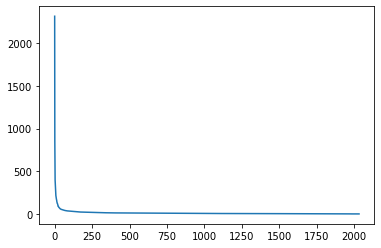

In [26]:
plt.plot(s);

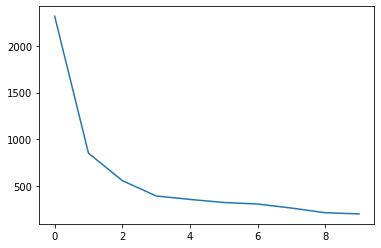

In [27]:
plt.plot(s[:10])

In [0]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [29]:
show_topics(Vh[:10])

['critus vpic60 ahhh alt.autotheism ditto yeager present.. rigth..',
 ", . '' `` jpeg wa jesus n't",
 ': ) ( $ - ; @ =',
 ": '' `` . god atheist jesus >",
 '. jpeg image file gif : format ?',
 '- : , [ image ] @ file',
 "- @ [ ] > . < ''",
 '; > ] [ = jpeg , image',
 '; > launch = . satellite space den',
 '? . jesus > ) + ( #']

## 3.2 Non-negative Matrix Factorization (NMF)

In [0]:
m,n=vectors.shape
d=5  # num topics

In [0]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [0]:
show_topics(H1)

# TF-IDF

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [0]:
newsgroups_train.data[10:20]

In [0]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [0]:
show_topics(H1)

In [0]:
plt.plot(clf.components_[0])

In [0]:
clf.reconstruction_err_

# Truncated SVD

In [0]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

In [0]:
from sklearn import decomposition
import fbpca

In [0]:
%time u, s, v = decomposition.randomized_svd(vectors, 10)

In [0]:
%time u, s, v = fbpca.pca(vectors, 10)

# Credit

* https://github.com/fastai/course-nlp
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* https://research.fb.com/fast-randomized-svd/